Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, Conv2D, MaxPool2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Rescaling
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from google.colab import drive

In [3]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#data_dir_train = pathlib.Path('/content/drive/MyDrive/Skin_images/Train')
#data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin_images/Test')

In [ ]:
!unzip '/content/gdrive/MyDrive/CNN_session_aug04/CNN_assignment.zip' -d '/content/gdrive/MyDrive/CNN_session_aug04/Dataset/'

Archive:  /content/gdrive/MyDrive/CNN_session_aug04/CNN_assignment.zip
replace /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

32
32


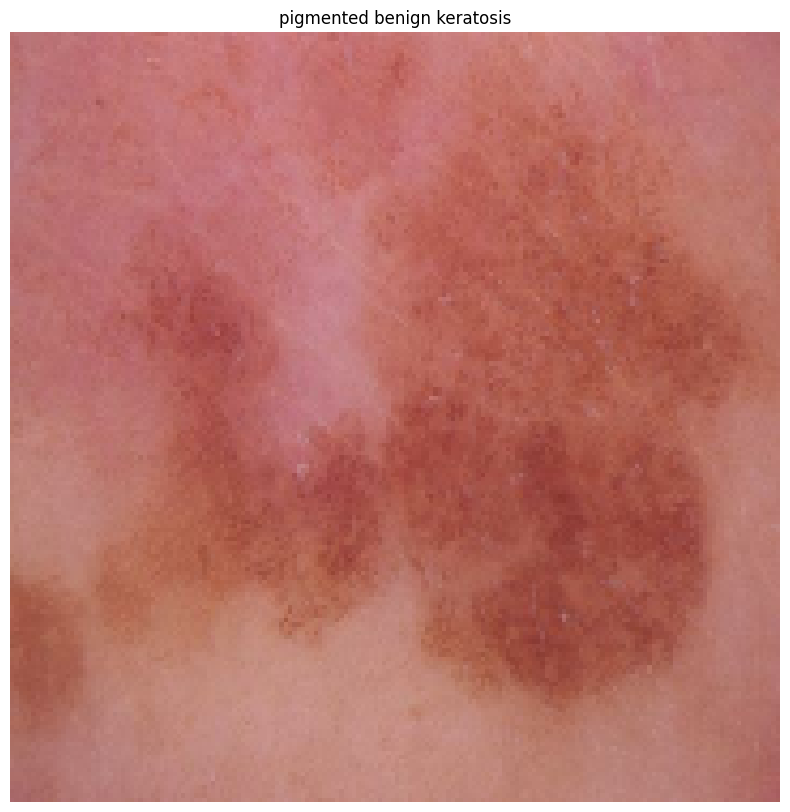

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title(class_names[labels[0]])
  plt.axis("off")

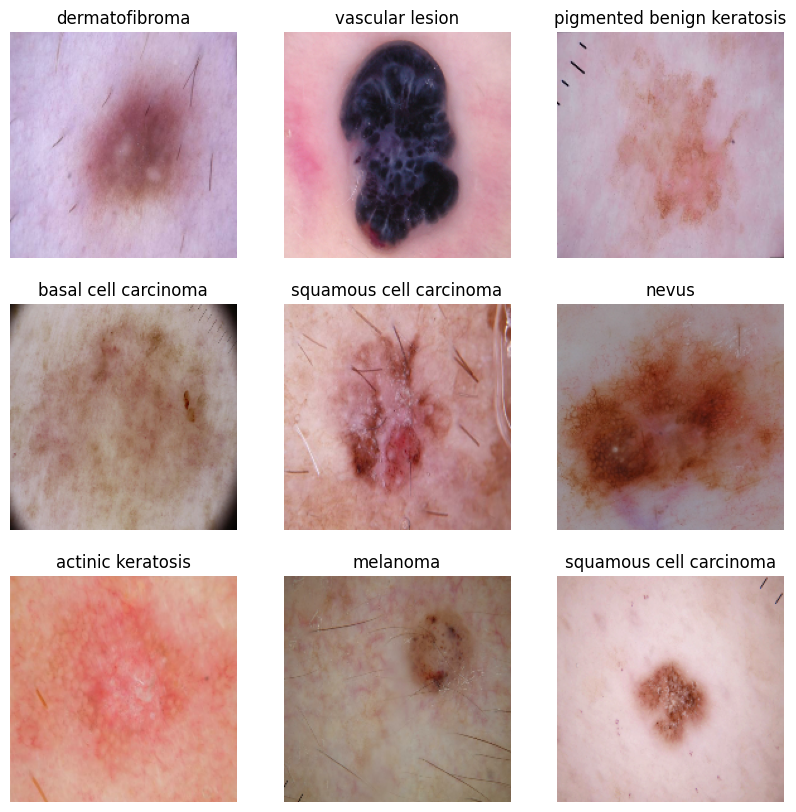

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [28]:
num_classes = 9
model = Sequential([
                    Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [29]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 45, 45, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 22, 22, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │          69,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,129 (1.06 MB)

 Trainable params: 277,129 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
### Todo, choose an appropirate optimiser and loss function
#model.compile(optimizer='adam',
#              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 45, 45, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 22, 22, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │          69,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,129 (1.06 MB)

 Trainable params: 277,129 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [32]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.1255 - loss: 2.1962 - val_accuracy: 0.1402 - val_loss: 2.1879
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.1334 - loss: 2.2039 - val_accuracy: 0.1282 - val_loss: 2.1908
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.1228 - loss: 2.2083 - val_accuracy: 0.1331 - val_loss: 2.1907
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.1194 - loss: 2.2195 - val_accuracy: 0.1366 - val_loss: 2.1890
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.1386 - loss: 2.1861 - val_accuracy: 0.1357 - val_loss: 2.8412
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.1351 - loss: 2.1873 - val_accuracy: 0.1629 - val_loss: 2.1387
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.2026 - loss: 2.0640 - val_accuracy: 0.2644 - val_loss: 1.9295
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.2879 - loss: 1.8545 - val_accurac

### Visualizing training results

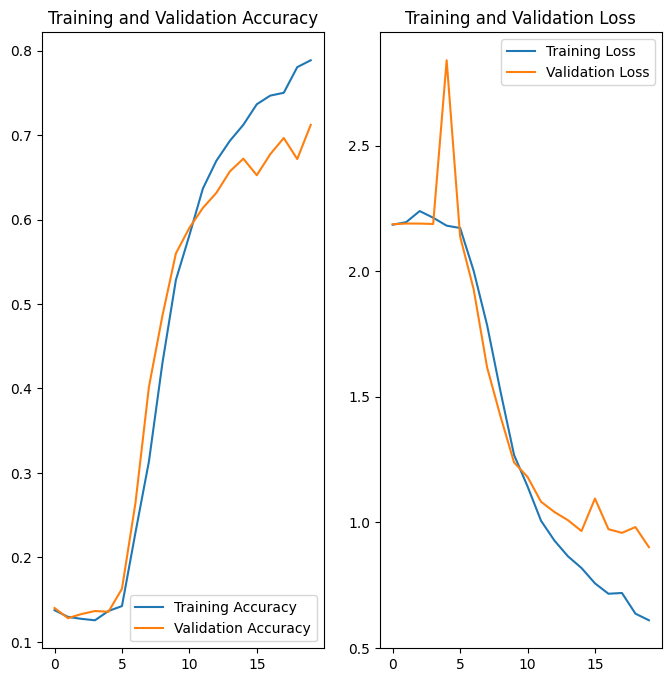

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [34]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8380 - loss: 0.4778
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7223 - loss: 0.8642
Accuracy:  0.834964394569397
Validation Accuracy:  0.7120605111122131
Loss:  0.49002861976623535
Validation Loss 0.9015435576438904


We can clearly see that the model's accuracy is low and loss is high, we need to chose right data augumentation strategy

### Write your findings here

In [42]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.2, fill_mode='reflect'),
                             layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


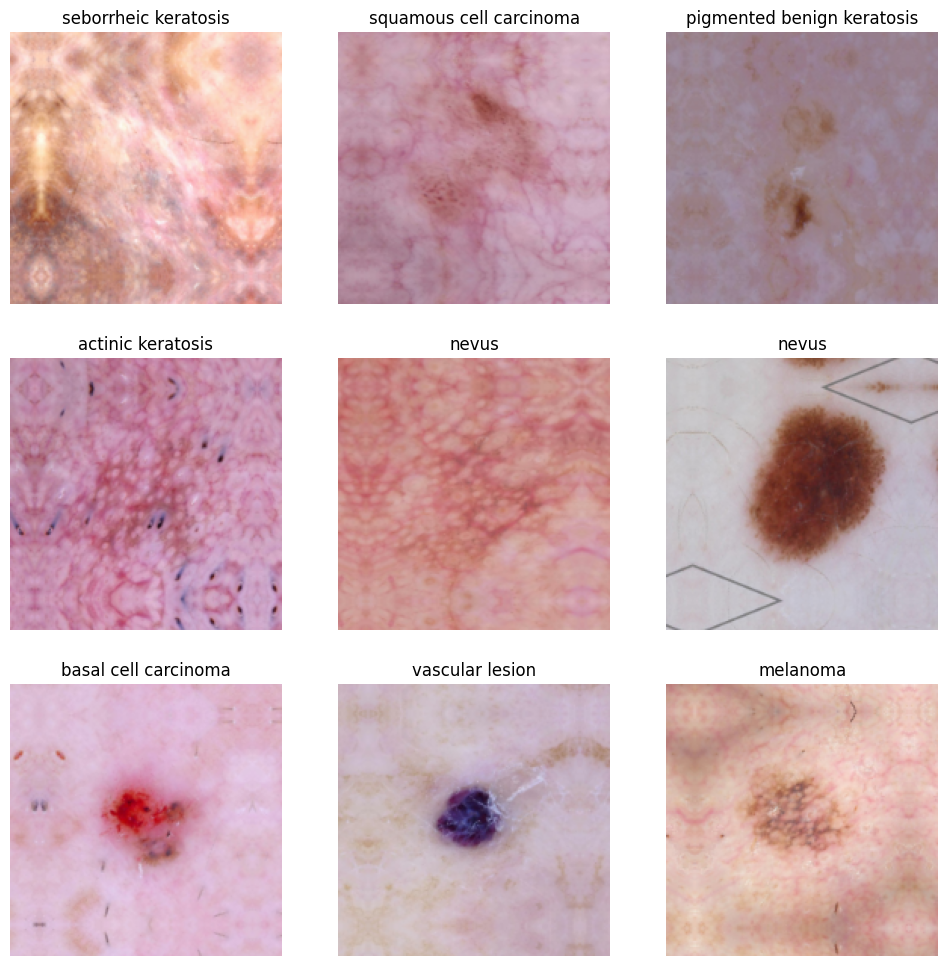

In [43]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [46]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compiling the model

In [47]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [48]:
## Your code goes here, note: train your model for 20 epochs
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


281/281 ━━━━━━━━━━━━━━━━━━━━ 26s 48ms/step - accuracy: 0.1319 - loss: 2.2194 - val_accuracy: 0.1126 - val_loss: 2.1945
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.1243 - loss: 2.1942 - val_accuracy: 0.1326 - val_loss: 2.1906
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1315 - loss: 2.1934 - val_accuracy: 0.1331 - val_loss: 2.1907
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.1231 - loss: 2.1942 - val_accuracy: 0.1331 - val_loss: 2.1903
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1266 - loss: 2.1910 - val_accuracy: 0.1277 - val_loss: 2.1904
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1251 - loss: 2.1926 - val_accuracy: 0.1331 - val_loss: 2.1900
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.1309 - loss: 2.1892 - val_accuracy: 0.1331 - val_loss: 2.1900
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.1289 - loss: 2.1907 - val_accurac

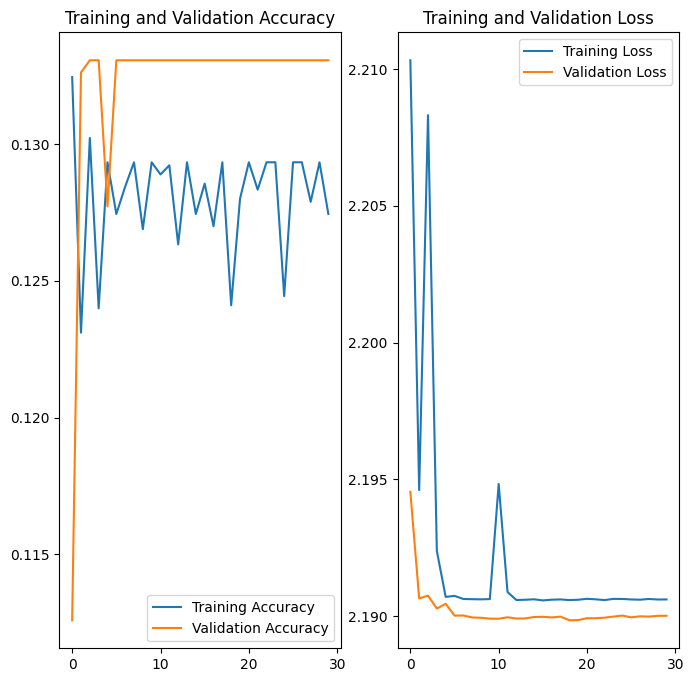

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1259 - loss: 2.1927
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1324 - loss: 2.1895
Accuracy:  0.12933719158172607
Validation Accuracy:  0.1330663114786148
Loss:  2.190391778945923
Validation Loss 2.1900107860565186


Still the accuracy is low , even though the loss has reduced. Lets try another strategy.

In [83]:
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
image_gen_train = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

# Create training images generator
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=data_dir_train,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=data_dir_test,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [84]:
model = Sequential()


model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=20
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5390 - loss: 1.3183 - val_accuracy: 0.3898 - val_loss: 2.1970
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5175 - loss: 1.3670 - val_accuracy: 0.3644 - val_loss: 2.4026
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5368 - loss: 1.2970 - val_accuracy: 0.3898 - val_loss: 2.1968
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5236 - loss: 1.3058 - val_accuracy: 0.3729 - val_loss: 2.2574
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5060 - loss: 1.3419 - val_accuracy: 0.3729 - val_loss: 2.0997
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5464 - loss: 1.2830 - val_accuracy: 0.4068 - val_loss: 2.1264
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5681 - loss: 1.2065 - val_accuracy: 0.4153 - val_loss: 2.2786
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5441 - loss: 1.2508 - val_accuracy: 0.3814 - val_loss:

### Visualizing the results

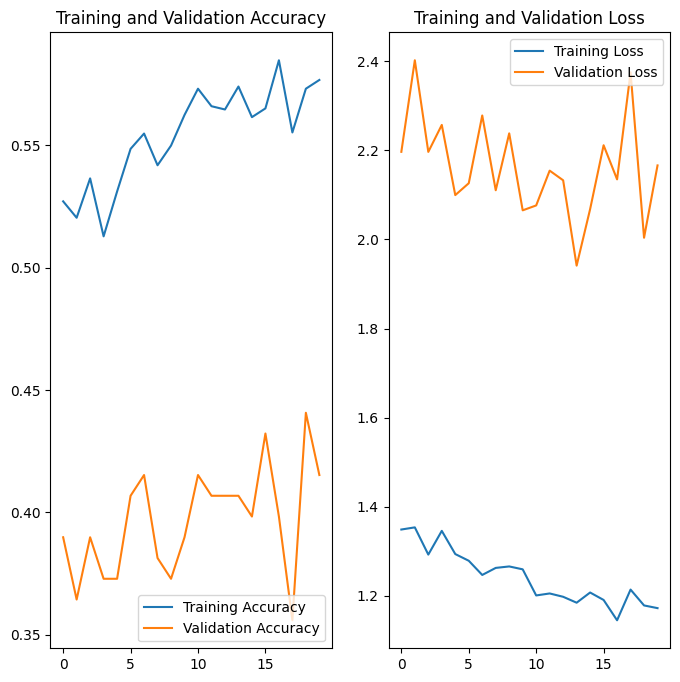

In [89]:
epochs = 20
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Still the model's accuracy is not as expected, there is an issue of class imbalance which needsto be addressed.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [58]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [59]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


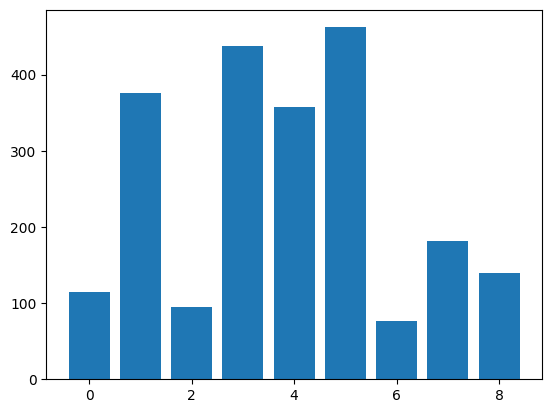

In [60]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [61]:
from sklearn.utils import class_weight
#Class=0, n=114 (5.092%)
#Class=1, n=376 (16.793%)
#Class=2, n=95 (4.243%)
#Class=3, n=438 (19.562%)
#Class=4, n=357 (15.945%)
#Class=5, n=462 (20.634%)
#Class=6, n=77 (3.439%)
#Class=7, n=181 (8.084%)
#Class=8, n=139 (6.208%)

class_weight = {0:5.09,
                1:16.79,
                2:4.24,
                3:19.56,
                4:15.94,
                5:20.63,
                6:3.43,
                7:8.08,
                8:6.20}

num_classes = 9


model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes)

])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.2341 - loss: 21.3044 - val_accuracy: 0.4393 - val_loss: 1.4814
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4274 - loss: 14.5757 - val_accuracy: 0.5167 - val_loss: 1.2994
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5216 - loss: 12.0085 - val_accuracy: 0.5696 - val_loss: 1.1130
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6347 - loss: 8.9567 - val_accuracy: 0.6097 - val_loss: 1.0397
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7227 - loss: 6.8149 - val_accuracy: 0.7170 - val_loss: 0.7485
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7822 - loss: 5.0330 - val_accuracy: 0.7623 - val_loss: 0.6152
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8390 - loss: 3.3689 - val_accuracy: 0.7770 - val_loss: 0.6185
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8555 - loss: 2.9837 - val_

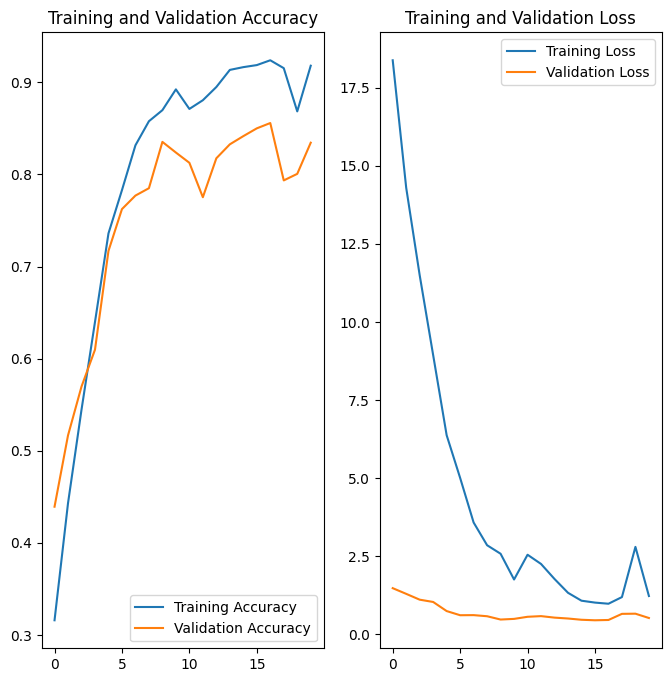

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [65]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [66]:
path_to_training_dataset=str(data_dir_train)

#print(path_to_training_dataset)
import Augmentor
for i in class_names:
    folder_name = path_to_training_dataset +"/" + i
    #print(folder_name)
    p = Augmentor.Pipeline(folder_name)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C927C39EBF0>: 100%|██████████| 500/500 [00:04<00:00, 112.28 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C9274BD4EB0>: 100%|██████████| 500/500 [00:04<00:00, 114.34 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C92E00FDAE0>: 100%|██████████| 500/500 [00:04<00:00, 111.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C927C1FB550>: 100%|██████████| 500/500 [00:13<00:00, 36.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C9274A209A0>: 100%|██████████| 500/500 [00:13<00:00, 36.01 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C927448EF20>: 100%|██████████| 500/500 [00:04<00:00, 110.38 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C9244165B70>: 100%|██████████| 500/500 [00:06<00:00, 72.83 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C9274DFF370>: 100%|██████████| 500/500 [00:04<00:00, 111.25 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_session_aug04/Dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C929210F310>: 100%|██████████| 500/500 [00:04<00:00, 110.90 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [67]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

13500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [68]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [69]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [70]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [71]:
original_df


,Path,Label
0,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion


In [72]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_session_aug04/Data...,actinic keratosis
...,...,...
13495,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
13496,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
13497,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion
13498,/content/gdrive/MyDrive/CNN_session_aug04/Data...,vascular lesion


In [73]:
new_df = pd.concat([original_df, df2], ignore_index=True)

In [74]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    1962
melanoma                      1938
basal cell carcinoma          1876
nevus                         1857
squamous cell carcinoma       1681
vascular lesion               1639
actinic keratosis             1614
dermatofibroma                1595
seborrheic keratosis          1577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [75]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [76]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 12592 files for training.


#### **Todo:** Create a validation dataset

In [77]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15739 files belonging to 9 classes.
Using 3147 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [78]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [79]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [80]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 38ms/step - accuracy: 0.3038 - loss: 1.7827 - val_accuracy: 0.5348 - val_loss: 1.2728
Epoch 2/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5842 - loss: 1.1199 - val_accuracy: 0.6991 - val_loss: 0.8702
Epoch 3/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7139 - loss: 0.7803 - val_accuracy: 0.7912 - val_loss: 0.6209
Epoch 4/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8099 - loss: 0.5299 - val_accuracy: 0.8046 - val_loss: 0.5751
Epoch 5/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8607 - loss: 0.4047 - val_accuracy: 0.8595 - val_loss: 0.4294
Epoch 6/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8834 - loss: 0.3234 - val_accuracy: 0.8672 - val_loss: 0.3865
Epoch 7/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9129 - loss: 0.2512 - val_accuracy: 0.8773 - val_loss: 0.4034
Epoch 8/20
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9162 - loss: 0.2326 - val_acc

#### **Todo:**  Visualize the model results

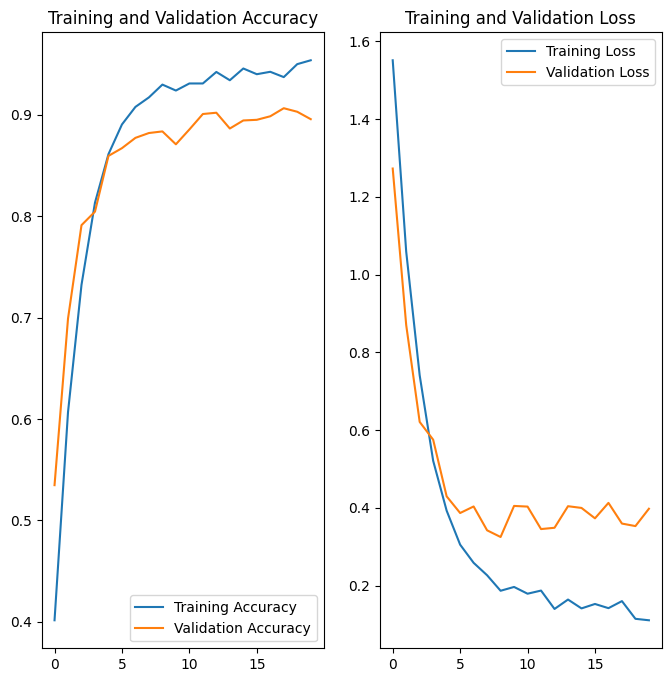

In [81]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [82]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

394/394 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9532 - loss: 0.1055
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8955 - loss: 0.4078
Accuracy:  0.953462541103363
Validation Accuracy:  0.8957737684249878
Loss:  0.10464989393949509
Validation Loss 0.3975450396537781


Now the accuracy of training and validation data is better, indicating the model has fitted well.